In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii

In [2]:
#Bruno's github codes

def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}


def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return


#amended code

def select_object_segmap(segmap,index):
    Regions = np.zeros_like(segmap)
    if index not in segmap:
        raise ValueError('index not in segmentation map')
    #print(np.where(segmap==index))
    Regions[segmap==index]=index
    return Regions

In [3]:
##############################
masterdata = ascii.read('/Volumes/PurpleDrive/mastertable')
masterdata
for i in masterdata['NUMBER_F105']:
    print(i)

413
635
1223
620
236
--
333
1297
819
547
702
309
268
1072
520
76
1369
1497
386
1429
1743
163
1397
532
1720
1379
1706
313
1862
1015
--
--
--
1829
--
1506
1761
2019
1658
--
1823
1550
--
2036
1241
1830
1662
2088
1966
--
1849
2100
2096
--
--
2068
--
1826
1841
--
--
2025
--
2280
2203
1744
--
--
--
--
--
--
--
--
--
--
--
--
--
2301
--
--
--
--
--
--
--
--
--


In [4]:
segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')#[0].data
segmap.filename()

'/Volumes/PurpleDrive/segmaps_check/F105W_check.fits'

In [5]:
collected_regions = []
index_list = []
def regions(filtername):
    xcs=[]
    ycs=[]
    #collected_regions = []
    masterdata = ascii.read('/Volumes/PurpleDrive/mastertable')
    segmap_file = pyfits.open('/Volumes/PurpleDrive/segmaps_check/{}_check.fits'.format(filtername))#[0].data
    segmap = segmap_file[0].data    
    for detection in masterdata: 
        if filtername is not 'F850LP': #need this b/c table colnames arent full filternames
            filter = filtername[:-1]
        else:
            filter = filtername[:-2]
        xc = detection["X_IMAGE_{}".format(filter)] #in pix #PARAMETER
        yc = detection["Y_IMAGE_{}".format(filter)] #in pix #PARAMETER
        pixscale = 0.06 #PARAMETER
        index = detection['NUMBER_{}'.format(filter)]
        radius=0.5 ##DEFAULT #PARAMETER
        index_list.append(index)
        xcs.append(xc)
        ycs.append(yc)
    #print('index shape:',np.shape(index_list),index_list)
    for index in index_list:
        if index.dtype == 'int64':
            #print(index)
            each_region = select_object_segmap(segmap,index) #indexing so have matching value so subtracting =0
        else:
            pass
        collected_regions.append(each_region)
        #print(np.shape(collected_regions))
    #print('second regions:',np.shape(each_region))
            #collected_regions.append(each_region)
    #print('final collected:',np.shape(collected_regions))
    return(collected_regions)

# testing for problem

In [6]:
collected_regions = []
index_list = []
F105_region = regions("F105W")

#for count,x in enumerate(ys): #20(2513,3133) #21 (,977)
#    print(count,x)


In [15]:
#first is the region info for galaxy detection #20
#the middle thing below is 1743 value which is the correct one for detection index 20
#third is seg map for galaxy detection #20
np.shape(F105_region[20]),F105_region[20][3122][2517],F105segmap[3122][2517],np.where(F105_region[20] > 0)

((4824, 4538),
 1743,
 1743,
 (array([3119, 3119, 3119, 3119, 3119, 3120, 3120, 3120, 3120, 3120, 3121,
         3121, 3121, 3121, 3121, 3122, 3122, 3122, 3122, 3122, 3122, 3123,
         3123, 3123, 3123, 3123, 3123, 3123, 3123, 3124, 3124, 3124, 3124,
         3124, 3124, 3124, 3124, 3124, 3124, 3125, 3125, 3125, 3125, 3125,
         3125, 3125, 3125, 3125, 3125, 3125, 3125, 3126, 3126, 3126, 3126,
         3126, 3126, 3126, 3126, 3126, 3126, 3126, 3126, 3126, 3127, 3127,
         3127, 3127, 3127, 3127, 3127, 3127, 3127, 3127, 3127, 3127, 3127,
         3128, 3128, 3128, 3128, 3128, 3128, 3128, 3128, 3128, 3128, 3128,
         3128, 3128, 3128, 3129, 3129, 3129, 3129, 3129, 3129, 3129, 3129,
         3129, 3129, 3129, 3129, 3129, 3129, 3129, 3130, 3130, 3130, 3130,
         3130, 3130, 3130, 3130, 3130, 3130, 3130, 3130, 3130, 3130, 3130,
         3130, 3131, 3131, 3131, 3131, 3131, 3131, 3131, 3131, 3131, 3131,
         3131, 3131, 3131, 3131, 3131, 3131, 3132, 3132, 3132, 3132, 31

In [11]:
testsum=np.sum(F105_region,axis=0)
F105segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')[0].data
F105mask = F105segmap - testsum#[0::]

In [13]:
np.shape(F105mask),np.shape(F105segmap),np.shape(segmap[0])

((4824, 4538), (4824, 4538), (4824, 4538))

# left off here , exploring value diffs

In [69]:
segmap[0].data[3122][2517] #this is 1743
F105mask[3122][2517] #wanted this to be 1 so it would be masked but its one



0

In [ ]:
np.shape(F105_region),

for arr in F105_region[20]:
    for val in arr:
        print(val)
        if val >0:
            print(val)
        #np.where(F105_region[20]>0)

(2413, 2613)

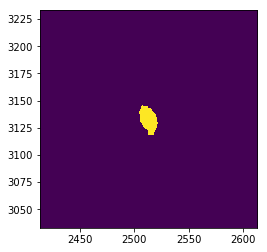

In [17]:
testsum=np.sum(F105_region,axis=0)
mpl.imshow(testsum,vmin=0,vmax=1)
mpl.ylim(3033,3233)
mpl.xlim(2413,2613)

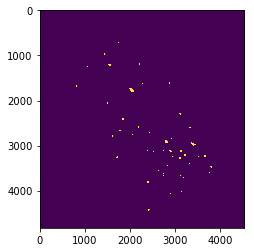

In [32]:
mpl.imshow(testsum,vmin=0,vmax=1)



In [36]:
np.shape(testsum[0::]),#testsum[2500:2525,3118:3147]
# for i in testsum[2413:2613,3033:3233]:
#     print(i)

((4824, 4538),)

In [37]:
F105segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')[0].data
F105image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F105W.fits')[0].data
F105mask = F105segmap - testsum[0::]

np.where(F105mask > 0)

(array([ 229,  229,  230, ..., 4616, 4616, 4616]),
 array([2086, 2087, 2085, ..., 2541, 2542, 2543]))

In [21]:
np.shape(F105segmap),np.shape(testsum),np.shape(F105mask)

((4824, 4538), (4824, 4538), (4824, 4538))

In [38]:
F105mask[4616][2543], F105mask[4616][2542]#[2500:2525][3100:3131]

(2326, 2326)

In [31]:
#np.where(F105mask == 1743) #nowhere
for row in F105mask:
    for count,i in enumerate(row): #up to 4537
        print(count,i)
    break
#     if i >0:
#         print(i)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


2149 0
2150 0
2151 0
2152 0
2153 0
2154 0
2155 0
2156 0
2157 0
2158 0
2159 0
2160 0
2161 0
2162 0
2163 0
2164 0
2165 0
2166 0
2167 0
2168 0
2169 0
2170 0
2171 0
2172 0
2173 0
2174 0
2175 0
2176 0
2177 0
2178 0
2179 0
2180 0
2181 0
2182 0
2183 0
2184 0
2185 0
2186 0
2187 0
2188 0
2189 0
2190 0
2191 0
2192 0
2193 0
2194 0
2195 0
2196 0
2197 0
2198 0
2199 0
2200 0
2201 0
2202 0
2203 0
2204 0
2205 0
2206 0
2207 0
2208 0
2209 0
2210 0
2211 0
2212 0
2213 0
2214 0
2215 0
2216 0
2217 0
2218 0
2219 0
2220 0
2221 0
2222 0
2223 0
2224 0
2225 0
2226 0
2227 0
2228 0
2229 0
2230 0
2231 0
2232 0
2233 0
2234 0
2235 0
2236 0
2237 0
2238 0
2239 0
2240 0
2241 0
2242 0
2243 0
2244 0
2245 0
2246 0
2247 0
2248 0
2249 0
2250 0
2251 0
2252 0
2253 0
2254 0
2255 0
2256 0
2257 0
2258 0
2259 0
2260 0
2261 0
2262 0
2263 0
2264 0
2265 0
2266 0
2267 0
2268 0
2269 0
2270 0
2271 0
2272 0
2273 0
2274 0
2275 0
2276 0
2277 0
2278 0
2279 0
2280 0
2281 0
2282 0
2283 0
2284 0
2285 0
2286 0
2287 0
2288 0
2289 0
2290 0
2291 0

3474 0
3475 0
3476 0
3477 0
3478 0
3479 0
3480 0
3481 0
3482 0
3483 0
3484 0
3485 0
3486 0
3487 0
3488 0
3489 0
3490 0
3491 0
3492 0
3493 0
3494 0
3495 0
3496 0
3497 0
3498 0
3499 0
3500 0
3501 0
3502 0
3503 0
3504 0
3505 0
3506 0
3507 0
3508 0
3509 0
3510 0
3511 0
3512 0
3513 0
3514 0
3515 0
3516 0
3517 0
3518 0
3519 0
3520 0
3521 0
3522 0
3523 0
3524 0
3525 0
3526 0
3527 0
3528 0
3529 0
3530 0
3531 0
3532 0
3533 0
3534 0
3535 0
3536 0
3537 0
3538 0
3539 0
3540 0
3541 0
3542 0
3543 0
3544 0
3545 0
3546 0
3547 0
3548 0
3549 0
3550 0
3551 0
3552 0
3553 0
3554 0
3555 0
3556 0
3557 0
3558 0
3559 0
3560 0
3561 0
3562 0
3563 0
3564 0
3565 0
3566 0
3567 0
3568 0
3569 0
3570 0
3571 0
3572 0
3573 0
3574 0
3575 0
3576 0
3577 0
3578 0
3579 0
3580 0
3581 0
3582 0
3583 0
3584 0
3585 0
3586 0
3587 0
3588 0
3589 0
3590 0
3591 0
3592 0
3593 0
3594 0
3595 0
3596 0
3597 0
3598 0
3599 0
3600 0
3601 0
3602 0
3603 0
3604 0
3605 0
3606 0
3607 0
3608 0
3609 0
3610 0
3611 0
3612 0
3613 0
3614 0
3615 0
3616 0

In [43]:
np.shape(F105mask),type(F105mask)#want F105mask[20]

((4824, 4538), numpy.ndarray)

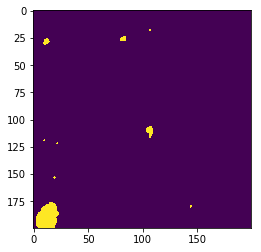

In [46]:

mpl.imshow(F105mask[2413:2613,3033:3233],vmin=0,vmax=1)

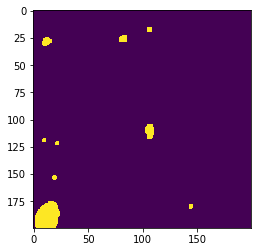

In [61]:
mpl.imshow(F105dilated_mask[2413:2613,3033:3233],vmin=0,vmax=1)

In [60]:
#always comes out to zero but clearly they have values, see above

# for row in F105mask[2413:2613,3033:3233]:#galaxy region
#     #print(i)
#     for val in row:
#         if val >0:
#             print(i) #should be some 1's
#         else:
#             continue
    #break
    
# for row in F105mask[1413:1613,1033:1233]:#[2500:2525,3100:3133]:
#     #print(i)
#     for val in row:
#         if val >0:
#             print(i)
#         else:
#             continue

In [63]:
np.where(F105mask > 0)

(array([   0,    0,    0, ..., 4823, 4823, 4823]),
 array([   0,    1,    2, ..., 4535, 4536, 4537]))

In [51]:
np.shape(F105segmap),np.shape(F105_final),np.shape(F105mask),type(F105mask)

((4824, 4538), (4824, 4538), (4824, 4538), numpy.ndarray)

# creates masks

In [42]:
collected_regions = []
index_list = []
F105_region = regions("F105W")
F105_final = np.sum(F105_region,axis=0)
F105segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')[0].data
F105image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F105W.fits')[0].data
F105mask = F105segmap - F105_final
F105mask[np.where(F105mask > 0)]=1 #to make areas not the galaxy =1
F105mask[F105image_data==0]=1
F105dilated_mask = sci_nd.binary_dilation(F105mask,structure=np.ones([3,3])).astype(np.int16)


#pyfits.writeto('/Volumes/PurpleDrive/F105W/dilated_mask.fits',F105dilated_mask,overwrite=True)
#pyfits.writeto('/Volumes/PurpleDrive/F105W/undilated_mask.fits',F105mask,overwrite=True)

In [7]:
#fuck a cycle, brut force
collected_regions = []
index_list = []
F125_region = regions("F125W")
F125_final = np.sum(F125_region,axis=0)
F125segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F125W_check.fits')[0].data
F125image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F125W.fits')[0].data
F125mask = F125segmap - F125_final
F125mask[np.where(F125mask > 0)]=1 #to make areas not the galaxy =1
F125mask[F125image_data==0]=1
F125dilated_mask = sci_nd.binary_dilation(F125mask,structure=np.ones([3,3])).astype(np.int16)


pyfits.writeto('/Volumes/PurpleDrive/F125W/dilated_mask.fits',F125dilated_mask,overwrite=True)
pyfits.writeto('/Volumes/PurpleDrive/F125W/undilated_mask.fits',F125mask,overwrite=True)

In [8]:
collected_regions = []
index_list = []
F140_region = regions("F140W")
F140_final = np.sum(F140_region,axis=0)
F140segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F140W_check.fits')[0].data
F140image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F140W.fits')[0].data
F140mask = F140segmap - F140_final
F140mask[np.where(F140mask > 0)]=1 #to make areas not the galaxy =1
F140mask[F140image_data==0]=1
F140dilated_mask = sci_nd.binary_dilation(F140mask,structure=np.ones([3,3])).astype(np.int16)


pyfits.writeto('/Volumes/PurpleDrive/F140W/dilated_mask.fits',F140dilated_mask,overwrite=True)
pyfits.writeto('/Volumes/PurpleDrive/F140W/undilated_mask.fits',F140mask,overwrite=True)

In [9]:
collected_regions = []
index_list = []
F160_region = regions("F160W")
F160_final = np.sum(F160_region,axis=0)
F160segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F160W_check.fits')[0].data
F160image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F160W.fits')[0].data
F160mask = F160segmap - F160_final
F160mask[np.where(F160mask > 0)]=1 #to make areas not the galaxy =1
F160mask[F160image_data==0]=1
F160dilated_mask = sci_nd.binary_dilation(F160mask,structure=np.ones([3,3])).astype(np.int16)


pyfits.writeto('/Volumes/PurpleDrive/F160W/dilated_mask.fits',F160dilated_mask,overwrite=True)
pyfits.writeto('/Volumes/PurpleDrive/F160W/undilated_mask.fits',F160mask,overwrite=True)

In [10]:
collected_regions = []
index_list = []
F435_region = regions("F435W")
F435_final = np.sum(F435_region,axis=0)
F435segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F435W_check.fits')[0].data
F435image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F435W.fits')[0].data
F435mask = F435segmap - F435_final
F435mask[np.where(F435mask > 0)]=1 #to make areas not the galaxy =1
F435mask[F435image_data==0]=1

F435dilated_mask = sci_nd.binary_dilation(F435mask,structure=np.ones([3,3])).astype(np.int16)
pyfits.writeto('/Volumes/PurpleDrive/F435W/dilated_mask.fits',F435dilated_mask,overwrite=True)
pyfits.writeto('/Volumes/PurpleDrive/F435W/undilated_mask.fits',F435mask,overwrite=True)

In [6]:
#trying to cycle

# regions_list =[]
# #for filter in filters:
# masks_list =[]
# def masks(filter):
#     each_region = regions(filter)
#     each_regionsum = np.sum(each_region,axis=0)
#     regions_list.append(each_regionsum)
    
#     for region in regions_list:
#         print('choosing this filter:',filter)
#         segmap_file = pyfits.open('/Volumes/PurpleDrive/segmaps_check/{}_check.fits'.format(filter))
#         segmap = segmap_file[0].data
#         image_file = pyfits.open('/Volumes/PurpleDrive/elgordo_{}.fits'.format(filter))
#         image_data = image_file[0].data
#         mask = segmap - region
#         masks_list.append(mask)
#     return (regions_list)

In [7]:
# filters = ['F105W','F125W']#,'F140W','F160W','F435W','F606W','F625W','F775W','F814W','F850LP']

# for i in filters:
#     idk = masks(i)
# print(np.shape(idk))

choosing this filter: F105W


ValueError: index not in segmentation map

In [22]:
# F105segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')[0].data
# F105image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_F105W.fits')[0].data
# F105mask = F105segmap - F105_final
# F105mask[np.where(F105mask > 0)]=1 #to make areas not the galaxy =1
# F105mask[F105image_data==0]=1 #to make outter area =1

x = masterdata['X_IMAGE_F105'][0]
y = masterdata['Y_IMAGE_F105'][0]


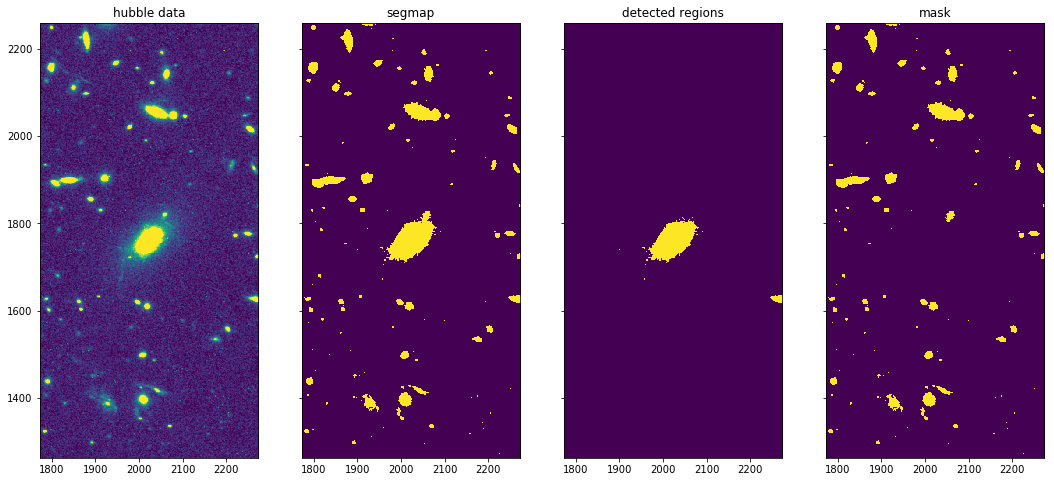

In [23]:
# fig, axis = mpl.subplots(1,4,figsize=(18,8),sharex=True,sharey=True)
# axis[0].imshow(F105image_data,vmin = -0.01,vmax = 0.1)
# axis[0].set_title('hubble data')
# axis[1].imshow(F105segmap,vmin=0,vmax=1)
# axis[1].set_title('segmap')
# axis[2].imshow(F105_final,vmin=0, vmax=1)
# axis[2].set_title('detected regions')
# axis[3].imshow(F105mask,vmin=0,vmax=1)
# axis[3].set_title('mask')

# for ax in axis:
#     #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
#     w = 250
#     ax.set_xlim(x-w,x+w)
#     ax.set_ylim(y-w,y+w)

In [ ]:
# ALL BELOW IS FOR ALL FILTERS, ABOVE IS SINGLE FILTER

In [16]:
#subtracting from segmap


# masks=[]
# for count,filter in enumerate(filters):
#     segmap = pyfits.open('/Volumes/PurpleDrive/segmaps_check/{}_check.fits'.format(filter))[0].data
#     mask = segmap - finalregions[count]
#     masks.append(mask)
# np.shape(masks) #one mask per filter

(10,)

In [17]:
# finalmasks = []

# for count,filter in enumerate(filters):
#     masks[count][np.where(masks[count] > 0)]=1
#     image_data = pyfits.open('/Volumes/PurpleDrive/elgordo_{}.fits'.format(filter))[0].data
#     masks[count][image_data==0]=1
#     finalmasks.append(masks)
# np.shape(finalmasks)

(10, 10)

In [24]:
#np.shape(finalmasks[0][0])

(4824, 4538)

In [18]:
image_dataF105 = pyfits.open('/Volumes/PurpleDrive/elgordo_F105W.fits')[0].data
segmapF105 = pyfits.open('/Volumes/PurpleDrive/segmaps_check/F105W_check.fits')[0].data

x = masterdata['X_IMAGE_F105'][0]
y = masterdata['Y_IMAGE_F105'][0]

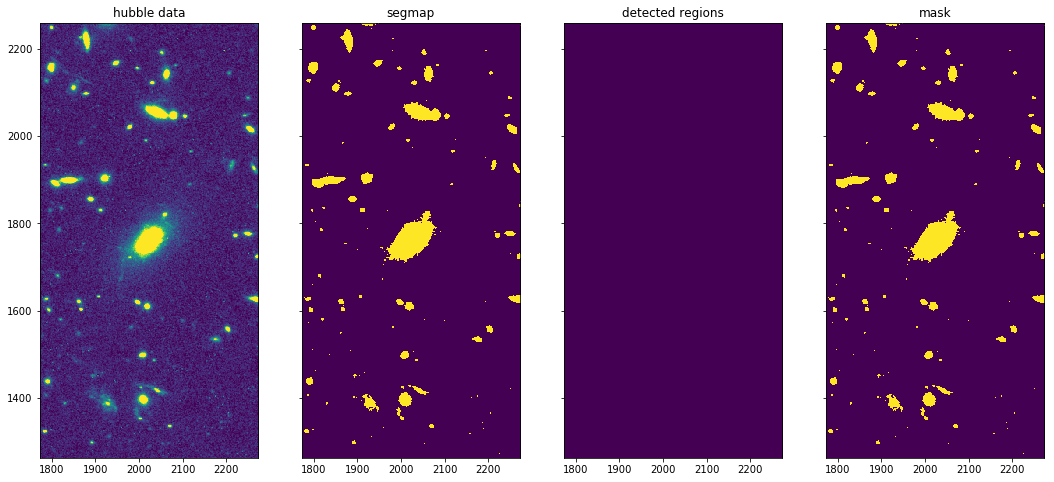

In [25]:
fig, axis = mpl.subplots(1,4,figsize=(18,8),sharex=True,sharey=True)
axis[0].imshow(image_dataF105,vmin = -0.01,vmax = 0.1)
axis[0].set_title('hubble data')
axis[1].imshow(segmapF105,vmin=0,vmax=1)
axis[1].set_title('segmap')
axis[2].imshow(finalregions[0],vmin=0, vmax=1)
axis[2].set_title('detected regions')
axis[3].imshow(finalmasks[0][0],vmin=0,vmax=1)
axis[3].set_title('mask')

for ax in axis:
    #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
    w = 250
    ax.set_xlim(x-w,x+w)
    ax.set_ylim(y-w,y+w)

In [ ]:
#later steps


#smoothing (ie increasing mask coverage to balance higher inital thresh when running SEx)

dilated_mask = sci_nd.binary_dilation(mask_file,structure=np.ones([3,3])).astype(np.int16)


In [ ]:
#saving files for a config run of galfit later

dilated_mask = sci_nd.binary_dilation(mask_file,structure=np.ones([3,3])).astype(np.int16)


pyfits.writeto('/data1/rowland/{}/dilated_mask.fits'.format(filtername),dilated_mask,overwrite=True)
pyfits.writeto('/data1/rowland/{}/undilated_mask.fits'.format(filtername),mask_file,overwrite=True)

In [ ]:

#writing galfit input files per detections (galaxy);need to do this per filter



#collecting data of detections i want galfit to fit (ie cluster galaxies)



model = 'sersic' #from bruno
modelsList = [] #FOR INDIVIDUAL DETECTIONS
object_numbers = []
xs = []
ys = []
modelsString = [] #FOR ALL DETECTIONS 

for detection in selection_ofgalaxies: #to only run on subset for testing
    ## DEFINING PARAMETERS
    num = detection['NUMBER'] #object detection number from SEx list
    ba = 1 - detection['ELLIPTICITY'] 
    pa = 90 - detection['THETA_IMAGE'] 
    x = detection['X_IMAGE'] 
    y = detection['Y_IMAGE']
    re = detection['FLUX_RADIUS']
    m = detection['MAG_AUTO']
    n = 4     #this is sersic index, 4 b/c mostly expecting distinct cores & extended disks
    list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
    object_numbers.append(num)
    xs.append(x) #so i can slice these the same as modelsList in next cell
    ys.append(y)
    modelsList.append(list_of_strings) #FOR INDIVIDUAL DETECTIONS INPUT FILES
    modelsString = ''.join(modelsList) #FOR ALL DETECTIONS INPUT FILE
    

In [ ]:
#this makes a galfit input file per detection but indexes them 1:len(detections), not by object number


for count, item in enumerate(modelsList, 0): #started at 0 to index x,y correctly
    with open(f'/data1/rowland/{filtername}/input_{count}.txt', 'w') as f: ####would manually change FILTER folder here
        magzpt = zeropoints[filtername] #from zeropoints for this filter
        sky = 0 #b/c images already background subtracted
        width = 150
        #indexing by order of detection (enumerate(object num in low to high order))
        x_range = (xs[count]-width,xs[count]+width) 
        y_range = (ys[count]-width, ys[count]+width)
        sconvbox = 100 #55 is closer to psf size #100 
        pixscale = 0.06
        strings_forgalfit = input_file(f,item,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                                       imgname='elgordo_{}.fits'.format(filtername),\
                                       outname="output{}.fits".format(count),\
                                       psfname='psf.fits',\
                                       maskname='dilated_mask_{}.fits'.format(filtername),\
                                       signame='none',fixpars=None)

In [ ]:
#this makes a galfit input file for entire filter's detections 


f_all = open("/data1/rowland/{}/input_{}_ALL.galfit".format(filtername,filtername), "w") #created a blank file to write to
magzpt = zeropoints[filtername] #from zeropoints for this filter
sky = 0 #b/c images already background subtracted
x_range =  (0,4538) #from image_file[0].data.shape (x,y)
y_range = (0,4824)  #from image_file[0].data.shape (x,y)
sconvbox = 100 #(4824, 4538)
pixscale = 0.06
strings_forgalfit = input_file(f_all,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                               imgname='elgordo_{}.fits'.format(filtername),\
                               outname="output_{}_ALL.fits".format(filtername),\
                               psfname='psf.fits',\
                               maskname='dilated_mask_{}.fits'.format(filtername),\
                               signame='none',fixpars=None)


In [ ]:
# RUN GALFIT



In [ ]:
for count, item in enumerate(modelsList, 0):
    print(count)
    image = get_pkg_data_filename('/data1/rowland/{}/output{}.fits'.format(filtername,count))
    image_1 = pyfits.getdata(image, ext=1) #original
    image_2 = pyfits.getdata(image, ext=2) #model
    image_3 = pyfits.getdata(image, ext=3) #residuals
    image_4 = image_3 / image_1 #residuals divided by originals
    
    #plotting output images
    f, (ax1,ax2,ax3,ax4) = mpl.subplots(1,4,sharey=True,figsize=(35,35))
    ax1.imshow(image_1,vmin=0,vmax=1)
    ax1.title.set_text('{}_First image/ original data'.format(count))
    ax2.imshow(image_2,vmin=0,vmax=1)
    ax2.title.set_text('{}_Second image/ FitModel'.format(count))
    ax3.imshow(image_3,vmin=0,vmax=1)
    ax3.title.set_text('{}_Third image/ Residuals'.format(count))
    ax4.imshow(image_4,vmin=0,vmax=1)
    ax4.title.set_text('{}_Fourth image -- Residuals/Original'.format(count))
    mpl.savefig('/data1/rowland/{}/output{}_galfit_images'.format(filtername,count))